# Brain Tumor Detection: EfficientNet, ResNet, XCeption
Source: https://www.kaggle.com/code/anitarostami/brain-tumor-detection-efficientnet-resnet-xception/notebook

In [2]:
%pip install -r requirements2.txt

  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm
from warnings import filterwarnings

# Print Dataset
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Data Preparation

In [9]:
X_train = []
y_train = []
labels = ['glioma','notumor','meningioma','pituitary']


image_size = 150
for i in labels:
    folderPath = os.path.join('dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 300/300 [00:00<00:00, 2188.28it/s]


### Data Visualization

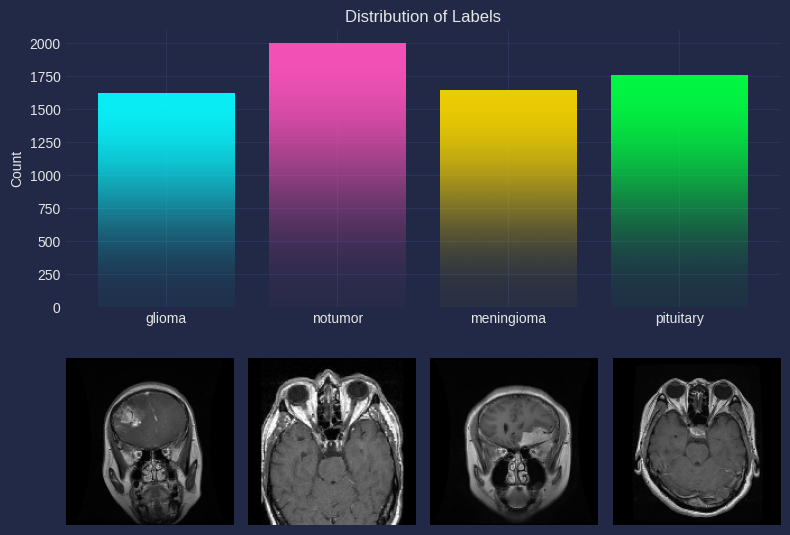

In [10]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1
        
plt.tight_layout()
plt.show()

### Dataset Split and Train

In [11]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

### One Hot Encoding Labels

In [12]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

### EfficientNet

In [48]:
# Load the EfficientNetB0 model pretrained on ImageNet without the top layers
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))


# Build the custom model on top of the EfficientNetB0 base
model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [14]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [15]:
history = model.fit(X_train,y_train,validation_split = 0.1, epochs = 12, verbose = 1,
                    batch_size = 32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12


I0000 00:00:1744598952.366170   14023 service.cc:148] XLA service 0x7c2a48015a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744598952.366192   14023 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1744598952.366195   14023 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-04-13 22:49:12.700024: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744598954.103111   14023 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-13 22:49:15.445231: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19511_0', 8 bytes spill stores, 8 bytes spill loads

2025-04-13 22:49:15.640882: I external/local_xla/xla/stream_execut

  5/178 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4292 - loss: 1.1961   

I0000 00:00:1744598969.994946   14023 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8395 - loss: 0.4426

2025-04-13 22:49:38.380255: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21388_0', 24 bytes spill stores, 24 bytes spill loads

2025-04-13 22:49:38.488687: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19511', 8 bytes spill stores, 8 bytes spill loads

2025-04-13 22:49:38.696033: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19511', 108 bytes spill stores, 108 bytes spill loads

E0000 00:00:1744598978.874548   14025 buffer_comparator.cc:157] Difference at 16: 0, expected 10.0531
E0000 00:00:1744598978.874569   14025 buffer_comparator.cc:157] Difference at 17: 0, expected 10.2398
E0000 00:00:1744598978.874571   14025 buffer_comparator.cc:157] Difference at 18: 0, e

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8398 - loss: 0.4419

2025-04-13 22:49:53.584811: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2084', 196 bytes spill stores, 196 bytes spill loads

E0000 00:00:1744598993.586646   14025 buffer_comparator.cc:157] Difference at 39: 472.156, expected 528.569
E0000 00:00:1744598993.586676   14025 buffer_comparator.cc:157] Difference at 55: 458.375, expected 533.637
E0000 00:00:1744598993.586677   14025 buffer_comparator.cc:157] Difference at 64: 0.843937, expected 512.719
E0000 00:00:1744598993.586679   14025 buffer_comparator.cc:157] Difference at 65: 1.18869, expected 529.412
E0000 00:00:1744598993.586680   14025 buffer_comparator.cc:157] Difference at 66: 1.13772, expected 521.502
E0000 00:00:1744598993.586681   14025 buffer_comparator.cc:157] Difference at 67: 0.999966, expected 526.731
E0000 00:00:1744598993.586682   14025 buffer_comparator.cc:157] Difference at 68: 0.855515, expected 512.801
E000


Epoch 1: val_accuracy improved from -inf to 0.85443, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 54s 152ms/step - accuracy: 0.8401 - loss: 0.4411 - val_accuracy: 0.8544 - val_loss: 0.5533 - learning_rate: 0.0010
Epoch 2/12
176/178 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9516 - loss: 0.1371
Epoch 2: val_accuracy did not improve from 0.85443
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9517 - loss: 0.1370 - val_accuracy: 0.8180 - val_loss: 0.6069 - learning_rate: 0.0010
Epoch 3/12
176/178 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9729 - loss: 0.0794
Epoch 3: val_accuracy improved from 0.85443 to 0.89241, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9727 - loss: 0.0800 - val_accuracy: 0.8924 - val_loss: 0.4540 - learning_rate: 0.0010
Epoch 4/12
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9726 - loss: 0.0859
Epoch 4: val_accuracy improved from 0.89241 to 0.95570, saving model to effi

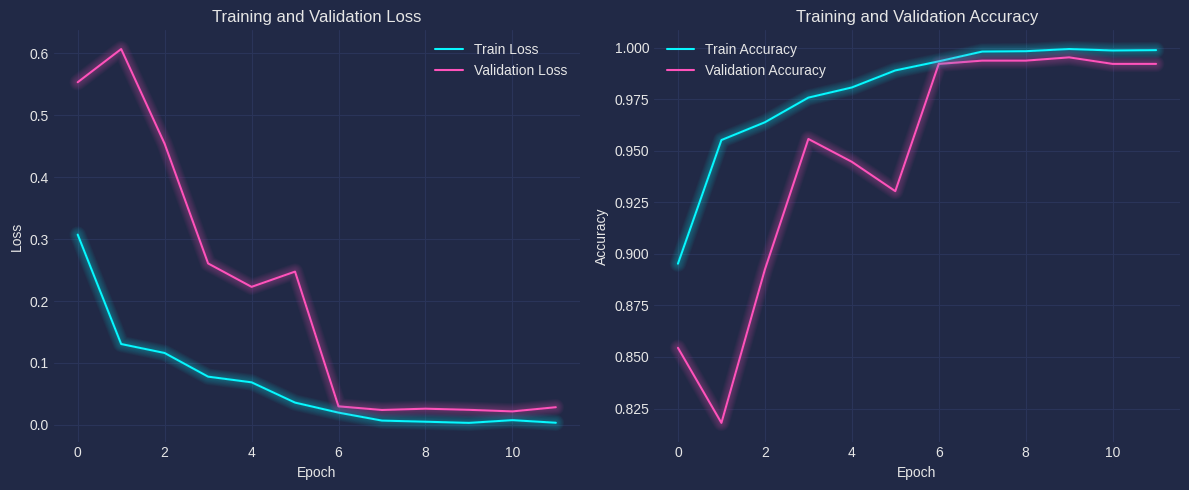

In [16]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()


### Evaluation

18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2025-04-13 22:51:21.527881: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2039', 4 bytes spill stores, 4 bytes spill loads

2025-04-13 22:51:21.591779: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2032', 216 bytes spill stores, 216 bytes spill loads

2025-04-13 22:51:21.667455: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2039', 184 bytes spill stores, 184 bytes spill loads

E0000 00:00:1744599081.668870   14033 buffer_comparator.cc:157] Difference at 64: 0, expected 523.571
E0000 00:00:1744599081.668887   14033 buffer_comparator.cc:157] Difference at 65: 2, expected 526.07
E0000 00:00:1744599081.668889   14033 buffer_comparator.cc:157] Difference at 66: 2, expec

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step


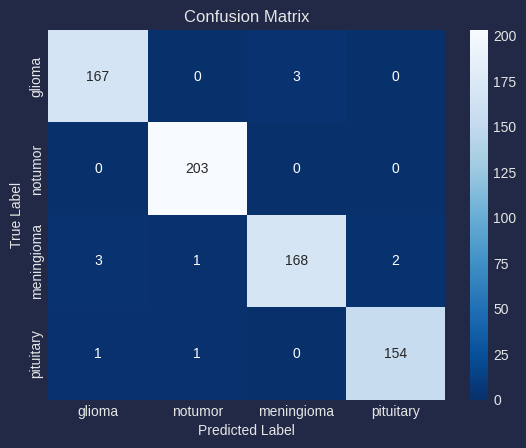

In [17]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [18]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       170
           1       0.99      1.00      1.00       203
           2       0.98      0.97      0.97       174
           3       0.99      0.99      0.99       156

    accuracy                           0.98       703
   macro avg       0.98      0.98      0.98       703
weighted avg       0.98      0.98      0.98       703



### Prediction

E0000 00:00:1744599102.799141   14025 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744599102.905010   14025 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744599103.067987   14025 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744599103.174116   14025 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744599103.280670   14025 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted label: notumor 
Actual label: notumor 
Confidence: 100.00%



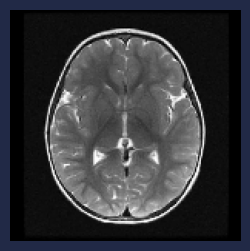

In [19]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

In [20]:
!nvidia-smi

Sun Apr 13 22:52:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0  On |                  N/A |
| 46%   34C    P5             43W /  350W |   22497MiB /  24576MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [26]:
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()


## ResNet101

In [34]:

# Load the ResNet101 model pretrained on ImageNet without the top layers
resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False,
                                         input_shape=(image_size, image_size, 3))

# Build the custom model on top of the ResNet101 base

model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 42,666,372 (162.76 MB)

 Trainable params: 42,561,028 (162.36 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [36]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [37]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15


E0000 00:00:1744599906.565150   14033 buffer_comparator.cc:157] Difference at 64: 6.96649e-07, expected 2.20132
E0000 00:00:1744599906.565173   14033 buffer_comparator.cc:157] Difference at 65: 8.10612e-07, expected 2.06797
E0000 00:00:1744599906.565175   14033 buffer_comparator.cc:157] Difference at 66: 2.99657e-07, expected 1.64481
E0000 00:00:1744599906.565176   14033 buffer_comparator.cc:157] Difference at 67: 1.24776e-07, expected 2.01379
E0000 00:00:1744599906.565177   14033 buffer_comparator.cc:157] Difference at 68: 2.64124e-07, expected 1.78577
E0000 00:00:1744599906.565178   14033 buffer_comparator.cc:157] Difference at 69: -5.33149e-07, expected 1.67553
E0000 00:00:1744599906.565179   14033 buffer_comparator.cc:157] Difference at 70: 2.06398e-07, expected 1.77877
E0000 00:00:1744599906.565180   14033 buffer_comparator.cc:157] Difference at 71: -1.42551e-08, expected 2.00766
E0000 00:00:1744599906.565181   14033 buffer_comparator.cc:157] Difference at 72: -6.33341e-08, expect

177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7316 - loss: 0.8245

E0000 00:00:1744599934.821817   14034 buffer_comparator.cc:157] Difference at 64: 0, expected 2.23785
E0000 00:00:1744599934.821837   14034 buffer_comparator.cc:157] Difference at 65: 0, expected 1.55976
E0000 00:00:1744599934.821839   14034 buffer_comparator.cc:157] Difference at 66: 0, expected 1.60761
E0000 00:00:1744599934.821840   14034 buffer_comparator.cc:157] Difference at 67: 0, expected 1.53937
E0000 00:00:1744599934.821841   14034 buffer_comparator.cc:157] Difference at 68: 0, expected 1.9815
E0000 00:00:1744599934.821842   14034 buffer_comparator.cc:157] Difference at 69: 0, expected 1.49197
E0000 00:00:1744599934.821842   14034 buffer_comparator.cc:157] Difference at 70: 0, expected 1.40088
E0000 00:00:1744599934.821843   14034 buffer_comparator.cc:157] Difference at 71: 0, expected 1.16058
E0000 00:00:1744599934.821844   14034 buffer_comparator.cc:157] Difference at 72: 0, expected 6.04391
E0000 00:00:1744599934.821845   14034 buffer_comparator.cc:157] Difference at 73: 0

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7320 - loss: 0.8231

2025-04-13 23:05:46.779645: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3321', 76 bytes spill stores, 76 bytes spill loads

E0000 00:00:1744599946.796893   14032 buffer_comparator.cc:157] Difference at 35: 23.3225, expected 20.5594
E0000 00:00:1744599946.796912   14032 buffer_comparator.cc:157] Difference at 64: 35.487, expected 20.9186
E0000 00:00:1744599946.796913   14032 buffer_comparator.cc:157] Difference at 65: 23.603, expected 21.0955
E0000 00:00:1744599946.796914   14032 buffer_comparator.cc:157] Difference at 66: 24.0234, expected 21.2528
E0000 00:00:1744599946.796916   14032 buffer_comparator.cc:157] Difference at 68: 24.8032, expected 20.9946
E0000 00:00:1744599946.796917   14032 buffer_comparator.cc:157] Difference at 69: 16.8, expected 21.2188
E0000 00:00:1744599946.796918   14032 buffer_comparator.cc:157] Difference at 70: 18.2418, expected 21.1212
E0000 00:00:17


Epoch 1: val_accuracy improved from -inf to 0.31646, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - accuracy: 0.7324 - loss: 0.8218 - val_accuracy: 0.3165 - val_loss: 1310.2928 - learning_rate: 0.0010
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9164 - loss: 0.2479
Epoch 2: val_accuracy improved from 0.31646 to 0.90032, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.9164 - loss: 0.2478 - val_accuracy: 0.9003 - val_loss: 0.5368 - learning_rate: 0.0010
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9450 - loss: 0.1648
Epoch 3: val_accuracy did not improve from 0.90032
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.9449 - loss: 0.1651 - val_accuracy: 0.7247 - val_loss: 2.5856 - learning_rate: 0.0010
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9553 - loss: 0.1456
Epoch 4: val_accuracy improved from 0.90032 to 0.91614, saving model t

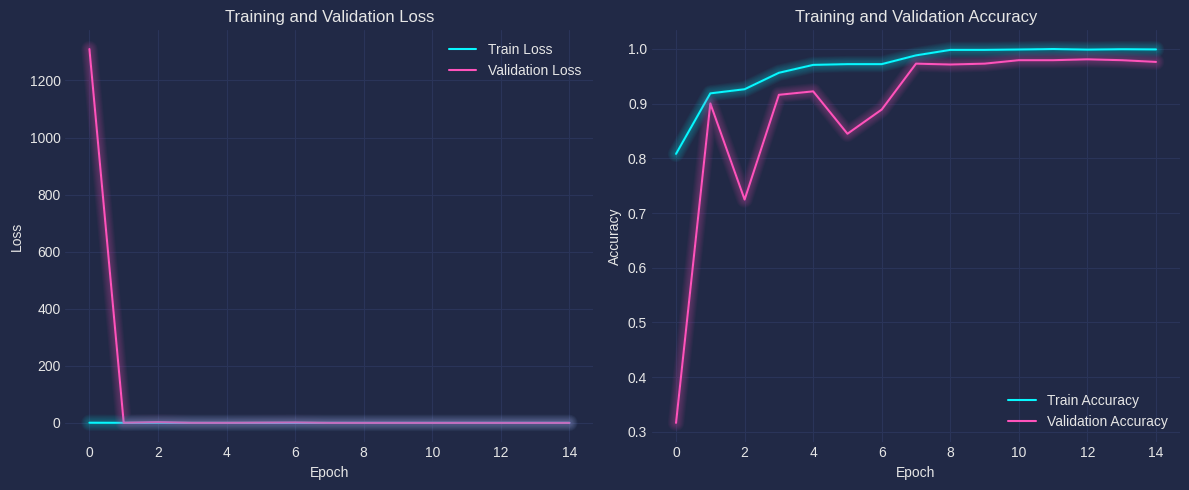

In [38]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

### Evaluation

2025-04-13 23:02:28.795224: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3276', 192 bytes spill stores, 192 bytes spill loads

E0000 00:00:1744599748.805514   14025 buffer_comparator.cc:157] Difference at 36: 18.0921, expected 20.4329
E0000 00:00:1744599748.805534   14025 buffer_comparator.cc:157] Difference at 64: 8, expected 21.0351
E0000 00:00:1744599748.805536   14025 buffer_comparator.cc:157] Difference at 65: 8, expected 21.023
E0000 00:00:1744599748.805537   14025 buffer_comparator.cc:157] Difference at 66: 8, expected 20.7641
E0000 00:00:1744599748.805538   14025 buffer_comparator.cc:157] Difference at 67: 8, expected 20.8296
E0000 00:00:1744599748.805538   14025 buffer_comparator.cc:157] Difference at 68: 8, expected 21.1176
E0000 00:00:1744599748.805539   14025 buffer_comparator.cc:157] Difference at 69: 8, expected 20.8684
E0000 00:00:1744599748.805540   14025 buffer

19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

2025-04-13 23:02:31.947225: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3276', 176 bytes spill stores, 176 bytes spill loads

E0000 00:00:1744599751.948522   14034 buffer_comparator.cc:157] Difference at 52: 18.537, expected 20.8719
E0000 00:00:1744599751.948542   14034 buffer_comparator.cc:157] Difference at 64: 6.62316, expected 21.1596
E0000 00:00:1744599751.948544   14034 buffer_comparator.cc:157] Difference at 65: 6.69596, expected 20.9341
E0000 00:00:1744599751.948545   14034 buffer_comparator.cc:157] Difference at 66: 6.67061, expected 21.019
E0000 00:00:1744599751.948546   14034 buffer_comparator.cc:157] Difference at 67: 6.47742, expected 20.3573
E0000 00:00:1744599751.948547   14034 buffer_comparator.cc:157] Difference at 68: 6.48388, expected 21.4978
E0000 00:00:1744599751.948548   14034 buffer_comparator.cc:157] Difference at 69: 6.48108, expected 20.7887
E0000 00:

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step


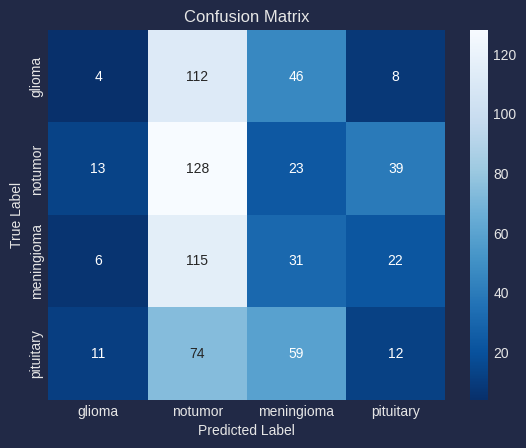

In [31]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [32]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.12      0.02      0.04       170
           1       0.30      0.63      0.41       203
           2       0.19      0.18      0.19       174
           3       0.15      0.08      0.10       156

    accuracy                           0.25       703
   macro avg       0.19      0.23      0.18       703
weighted avg       0.20      0.25      0.20       703



## Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label: notumor 
Actual label: meningioma 
Confidence: 72.78%



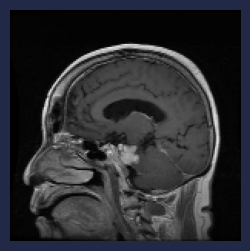

In [33]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

## XCeption

In [39]:
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()

In [40]:
# Load the Xception model pretrained on ImageNet without the top layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))

# Build the custom model on top of the Xception base
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1536,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [41]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 74, 74,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 74, 74,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 72, 72,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 72, 72,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 72, 72,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 72, 72,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 72, 72,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 72, 72,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 72, 72,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 72, 72,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 36, 36,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 36, 36,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 36, 36,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 36, 36,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 36, 36,    │          0 │ add[0][0]       

 Total params: 24,014,892 (91.61 MB)

 Trainable params: 23,960,364 (91.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [42]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [43]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12


2025-04-13 23:21:07.517276: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11292', 144 bytes spill stores, 388 bytes spill loads

2025-04-13 23:21:07.543766: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12845', 56 bytes spill stores, 56 bytes spill loads

2025-04-13 23:21:07.578892: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11292_0', 76 bytes spill stores, 116 bytes spill loads

2025-04-13 23:21:07.723284: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12845_0', 32 bytes spill stores, 32 bytes spill loads

E0000 00:00:1744600867.767451   14032 buffer_comp

177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8020 - loss: 0.5661

2025-04-13 23:21:27.627340: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11292', 16 bytes spill stores, 16 bytes spill loads

2025-04-13 23:21:27.858452: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11292_0', 52 bytes spill stores, 52 bytes spill loads

2025-04-13 23:21:27.933556: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11292', 20 bytes spill stores, 44 bytes spill loads

2025-04-13 23:21:27.995577: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12845_0', 28 bytes spill stores, 28 bytes spill loads

E0000 00:00:1744600888.152143   14032 buffer_compara

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8024 - loss: 0.5652

2025-04-13 23:21:36.708111: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1066', 200 bytes spill stores, 200 bytes spill loads

E0000 00:00:1744600896.711675   14025 buffer_comparator.cc:157] Difference at 64: 16.8188, expected 770.446
E0000 00:00:1744600896.711696   14025 buffer_comparator.cc:157] Difference at 65: 16.9846, expected 775.623
E0000 00:00:1744600896.711697   14025 buffer_comparator.cc:157] Difference at 66: 15.544, expected 779.887
E0000 00:00:1744600896.711698   14025 buffer_comparator.cc:157] Difference at 67: 16.1234, expected 776.089
E0000 00:00:1744600896.711700   14025 buffer_comparator.cc:157] Difference at 68: 19.0618, expected 777.27
E0000 00:00:1744600896.711701   14025 buffer_comparator.cc:157] Difference at 69: 18.6711, expected 779.97
E0000 00:00:1744600896.711702   14025 buffer_comparator.cc:157] Difference at 70: 16.7581, expected 778.46
E0000 00:00


Epoch 1: val_accuracy improved from -inf to 0.52215, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.8027 - loss: 0.5643 - val_accuracy: 0.5222 - val_loss: 2.1282 - learning_rate: 0.0010
Epoch 2/12
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9449 - loss: 0.1597
Epoch 2: val_accuracy improved from 0.52215 to 0.63766, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9449 - loss: 0.1597 - val_accuracy: 0.6377 - val_loss: 2.5270 - learning_rate: 0.0010
Epoch 3/12
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9620 - loss: 0.1448
Epoch 3: val_accuracy improved from 0.63766 to 0.91139, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9620 - loss: 0.1447 - val_accuracy: 0.9114 - val_loss: 0.2574 - learning_rate: 0.0010
Epoch 4/12
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9711 - loss: 0.0946
Epoch 4: val_accuracy improved f

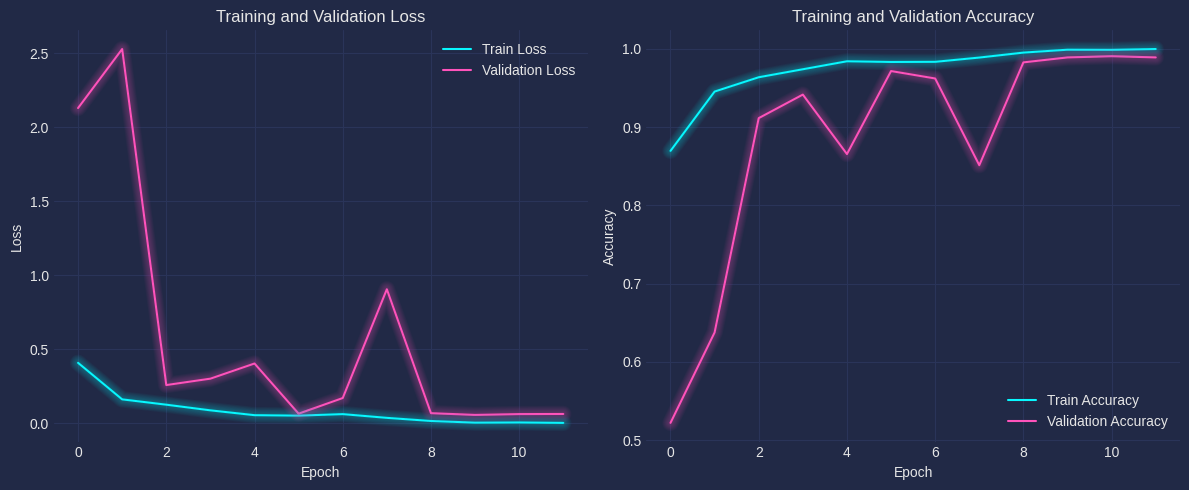

In [44]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

### Evaluation

18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

2025-04-13 23:37:39.588441: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1021', 4 bytes spill stores, 4 bytes spill loads

2025-04-13 23:37:39.726313: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1014_0', 108 bytes spill stores, 296 bytes spill loads

2025-04-13 23:37:39.799444: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1021', 188 bytes spill stores, 188 bytes spill loads

2025-04-13 23:37:39.880155: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1014', 176 bytes spill stores, 436 bytes spill loads

E0000 00:00:1744601859.881576   14034 buffer_comparato

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step


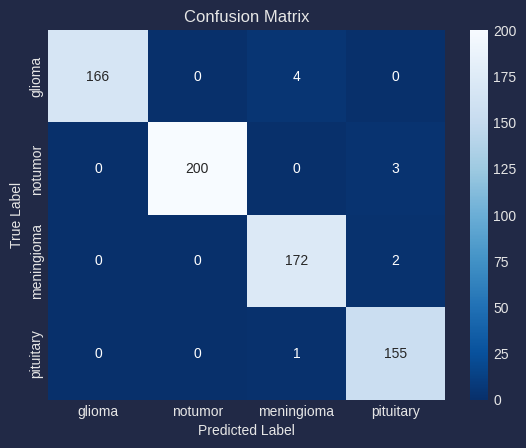

In [45]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [46]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       170
           1       1.00      0.99      0.99       203
           2       0.97      0.99      0.98       174
           3       0.97      0.99      0.98       156

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



### Prediction

E0000 00:00:1744601870.181085   14034 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744601870.284303   14034 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744601870.451354   14034 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744601870.554391   14034 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744601870.657866   14034 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: pituitary 
Actual label: pituitary 
Confidence: 100.00%



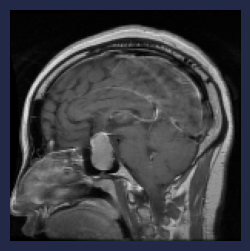

In [47]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class] 

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()